In [2]:
from data_generation import generate_batch
from polynomial_regression import PolyRegNp, PolyRegTorch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Text(0, 0.5, 'Adjusted Flux')

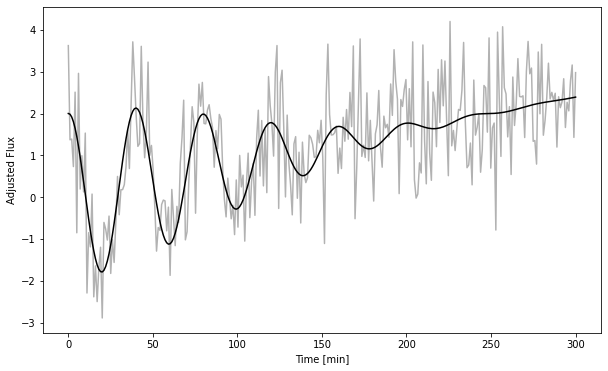

In [3]:
#Quasiperiodic function
#https://github.com/RileyWClarke/QPP-GP

def qpp_model(t,A,B,tau_g,P,phase):
    
    F = A*np.exp(-(t-B)**2/(2*tau_g**2))*np.cos(((2*np.pi)/P)*t+phase) + 0.008*t  
    return F

#QPP Model w/ random noise

X = np.linspace(0, 300, 300)
P = 40 # TRUE PERIOD

QPP = qpp_model(X,2,0,90,P,0)
#yerr = np.random.uniform(0.05, 0.2, len(X))
#y = QPP + yerr * np.random.randn(len(X))
np.random.seed(1)

y = QPP + np.random.randn(len(X))
true_y = QPP

plt.figure(figsize=(10,6))
plt.plot(X, true_y, "k", lw=1.5)
plt.plot(X, y,'k',alpha=0.3)
plt.xlabel("Time [min]")
plt.ylabel("Adjusted Flux")

# Polynomial Regression

polynomial regression model for a single predictor, X, is:

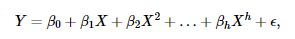

where h is called the degree of the polynomial. For lower degrees, the relationship has a specific name (i.e., h = 2 is called quadratic, h = 3 is called cubic, h = 4 is called quartic, and so on). 

Although this model allows for a nonlinear relationship between Y and X, polynomial regression is still considered linear regression since it is linear in the regression coefficients β1, β2,..., βh!

https://online.stat.psu.edu/stat462/node/158/#:~:text=Although%20this%20model%20allows%20for,.%20.%20.%20%2C%20%CE%B2%20h%20

https://stats.stackexchange.com/questions/92065/why-is-polynomial-regression-considered-a-special-case-of-multiple-linear-regres

## Lineer Regression Assumption:

 data = model + noise 


noise is a kind of gaussian or normal distribution so we need to check the residual by using the normality test (Shapiro-Wilk) but first let's look at trend.

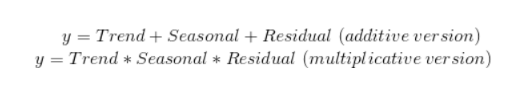

https://towardsdatascience.com/time-series-in-python-part-2-dealing-with-seasonal-data-397a65b74051

# Trend Analysis

X.shape -> (168,) 

X_scaled.shape -> (168, 1)

y.shape -> (168, 1)

In [3]:
reg = PolyRegNp(X,y)
X_scaled, y = reg.feature_scaling()
coef = reg.fit(degree=1)
m, b = coef[0], coef[1]
y_pred = reg.predict()

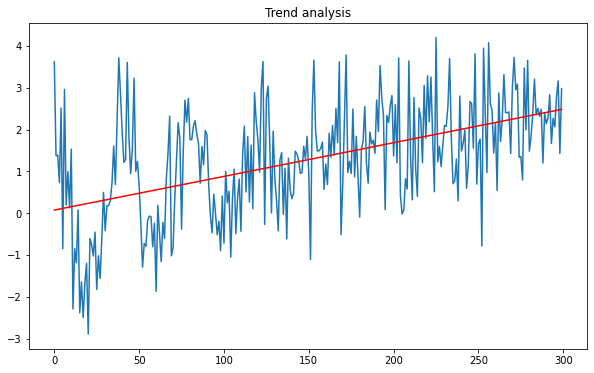

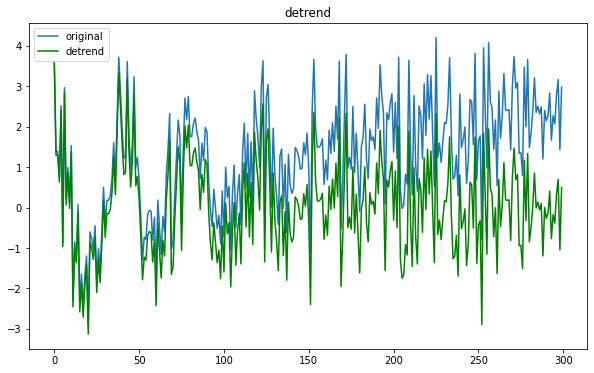

In [4]:
plt.figure(figsize = (10, 6))
plt.title('Trend analysis')
plt.plot(y)
plt.plot(y_pred, c='red')


detrend = (y - np.array(y_pred).reshape(-1,1)).flatten()
plt.figure(figsize = (10, 6))
plt.title('detrend')
plt.plot(y)
plt.plot(detrend, c='green')
plt.legend(['original', 'detrend'])

# Seasonality

According to Taylor Series, 4th order polynomial can represent sinusoidal components

In [5]:
reg = PolyRegNp(X,detrend)
X_scaled, detrend = reg.feature_scaling()
#coef_detrend = reg.fit(degree=4)
coef_detrend = reg.fit(degree=4)
y_pred_detrend = reg.predict()

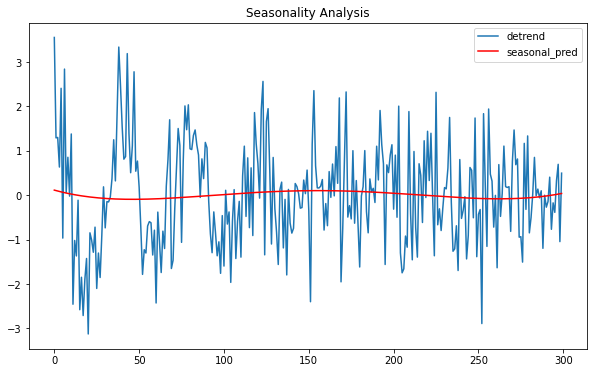

In [6]:
plt.figure(figsize = (10, 6))
plt.title('Seasonality Analysis')
plt.plot(detrend)
plt.plot(y_pred_detrend, c='red')
plt.legend(['detrend', 'seasonal_pred'])

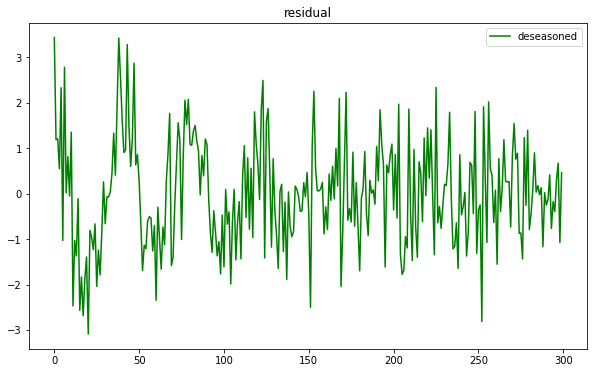

In [7]:
#residual
#deseasoned = detrend.flatten() - np.array(data[2]).reshape(-1,1).flatten()
deseasoned = detrend.flatten() - np.array(y_pred_detrend).reshape(-1,1).flatten()

plt.figure(figsize = (10, 6))
plt.title('residual')
plt.plot(deseasoned, c='green')
plt.legend(['deseasoned'])

# Seasonality and trend analysis by using statsmodels

time series analysis seasonal decomposition (statsmodels)

Hodrick-Prescott trend, cycle filter (statsmodels)

<Figure size 432x288 with 0 Axes>

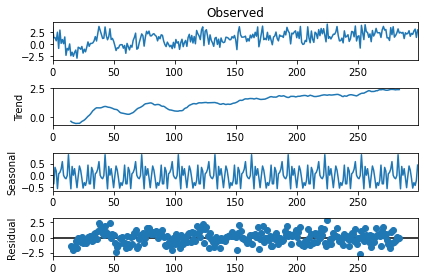

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(y, model='additive', period=30)
fig = plt.figure()
fig = decomposition.plot()

residual_stm = decomposition.resid
seasonal_stm = decomposition.seasonal 
trend_stm = decomposition.trend


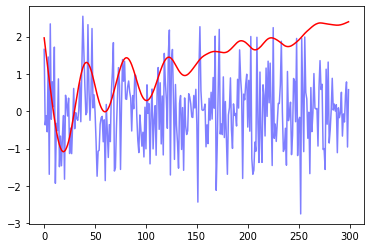

In [22]:
import statsmodels.api as sm

cycle_hpf, trend_hpf = sm.tsa.filters.hpfilter(y, 1600)
plt.figure()
plt.plot(cycle_hpf,'blue',alpha=0.5)
plt.plot(trend_hpf, 'red')

# now fit polynomial regression to all data

In [8]:
reg = PolyRegNp(X,y)
X_scaled, y = reg.feature_scaling()
#coef = reg.fit(degree=4)
coef = reg.fit(degree=20)
y_pred_d4 = reg.predict()

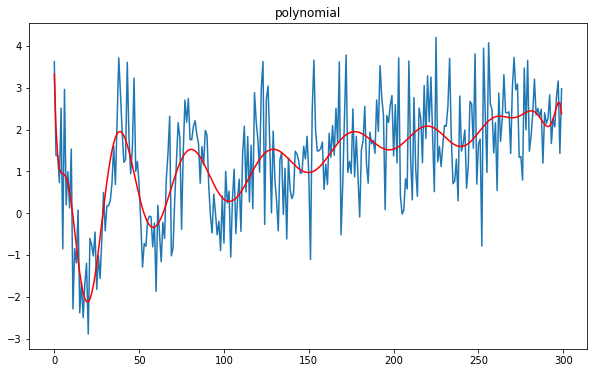

In [9]:
plt.figure(figsize = (10, 6))
plt.title('polynomial')
plt.plot(y)
plt.plot(y_pred_d4, c='red')

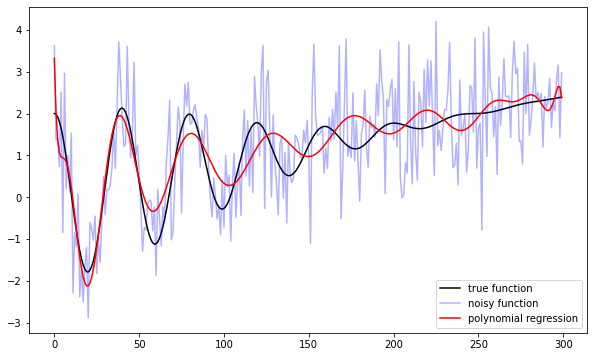

In [10]:
poly_pred = np.array(y_pred_d4).flatten()
plt.figure(figsize = (10, 6))
plt.plot(true_y, "k", lw=1.5)
plt.plot(y.flatten(), c = 'b', alpha=0.3)
plt.plot(poly_pred, c='red')
plt.legend(['true function', 'noisy function', 'polynomial regression'])

Text(0.5, 0, 'basis location')

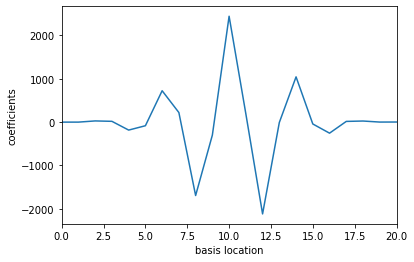

In [15]:
plt.plot(coef)
plt.xlim((0, 20))
plt.ylabel('coefficients')
plt.xlabel('basis location')


# Shapiro-Wilk Test

The Shapiro-Wilk test is a statistical test of the hypothesis that the distribution of the data as a whole deviates from a comparable normal distribution.

If the test is non-significant (p>. 05) it tells us that the distribution of the sample is not significantly different from a normal distribution.

https://uc-r.github.io/assumptions_normality#:~:text=The%20Shapiro%2DWilk%20test%20is,different%20from%20a%20normal%20distribution.

polynomial model:

In [17]:
from scipy import stats
residual = y.flatten() - poly_pred
val, pval = stats.shapiro(residual)
if pval > 0.05:
    print('normal distribution')
else:
    print('different from a normal distribution')
print ('p-value =', pval)

normal distribution
p-value = 0.6602874994277954


Statsmodel:

In [17]:
from scipy import stats
val, pval = stats.shapiro(residual_stm)
if pval > 0.05:
    print('normal distribution')
else:
    print('different from a normal distribution')
print ('p-value =', pval)

normal distribution
p-value = 1.0


# Emprical Wavelet Transform (Time - Frequency Analysis)

The main idea is to extract the different modes of a signal by designing an appropriate wavelet filter bank. This construction leads us to build adaptive wavelets called the empirical wavelet transform.

https://ieeexplore.ieee.org/document/6522142

Text(0.5, 0.98, 'Frequency Decomposition')

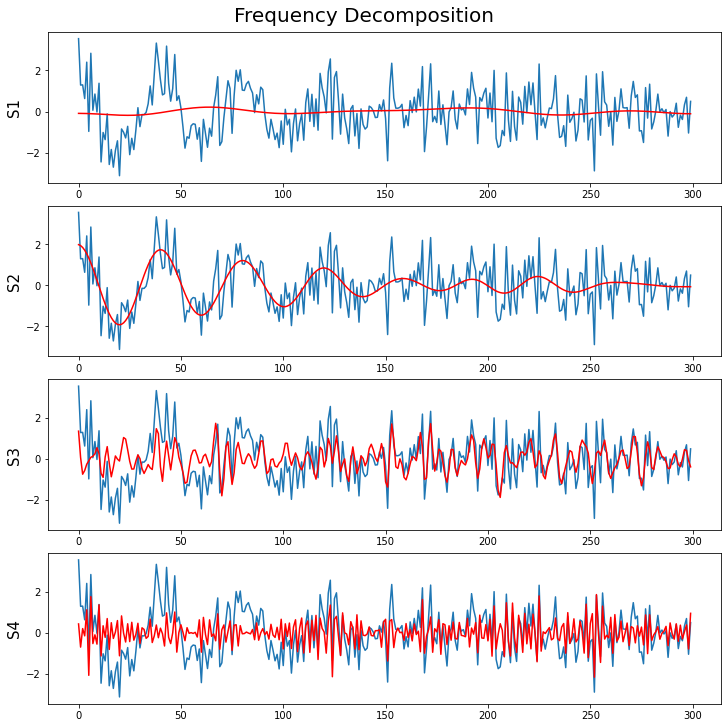

In [18]:
from emprical_wavelet_transform import EWT1D

#Splitting Data into N Sublayers using EWT
N = 4
data = EWT1D(detrend.flatten(), N = N)[0]
data = data.T

fig, ax = plt.subplots(N, 1, constrained_layout = True, figsize = (10, 10))
for i in range(N):
    ax[i].plot(detrend)
    ax[i].plot(data[i],c='r')
    ax[i].set_ylabel('S{}'.format(i+1), fontsize = 15)
fig.suptitle('Frequency Decomposition', fontsize = 20)


# Singular Spectrum Analysis

In time series analysis, singular spectrum analysis (SSA) is a nonparametric spectral estimation method. It combines elements of classical time series analysis, multivariate statistics, multivariate geometry, dynamical systems and signal processing.

https://en.wikipedia.org/wiki/Singular_spectrum_analysis

https://ui.adsabs.harvard.edu/abs/2019GeoJI.217..748P/abstract

https://github.com/dmarienko/chaos/blob/master/SSA_for_stock_prices_prediction.ipynb

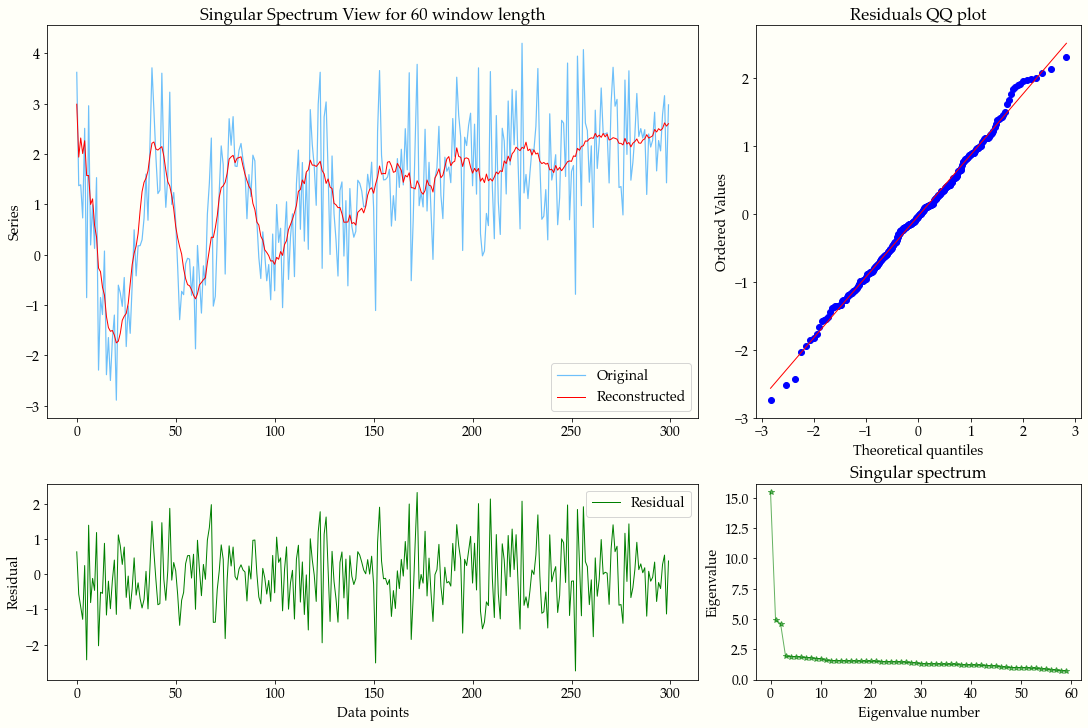

In [9]:
from ssa_core import ssa, ssa_predict, ssaview, inv_ssa, ssa_cutoff_order
from mpl_utils import set_mpl_theme

%matplotlib inline

plt.rcParams.update({ "axes.prop_cycle": plt.cycler("color", ['#000000', '#1b6989', '#e69f00', '#009e73', '#f0e442', '#50b4e9', '#d55e00', '#cc79a7']), "font.serif": ['Palatino', 'Palatino Linotype', 'Palatino LT STD', 'Book Antiqua', 'Georgia', 'DejaVu Serif'], 'font.family': 'serif', 'figure.facecolor': '#fffff8', 'axes.facecolor': '#fffff8', 'figure.constrained_layout.use': True, 'font.size': 14.0, 'hist.bins': 'auto', 'lines.linewidth': 1.0, })
plt.figure(figsize = (15,10))
ssaview(y, 60, [0,1,2,3])